# CSC2042S Assignment 1: World Developement Indicators
###### Author: Joshua Vieira (VRXJOS003)
### Data Preprocessing
First we must import all the necessary libraries we will be using.

In [91]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score



We need to transform our CSV file into basically a wide format. That means that we want a row for each country-year (country, year) pair where the columns are all the indicators. So for example, we want our file to look like this 

**Country Name|Country Code|Year|GDP|Life Expectancy|...|Indicator n**  

**South Africa|ZAF|1960|1000|60|...|x**

We will use pandas and numpy to do this.
First we "melt" our data, this means instead of having columns as years, we make the years as rows.
Then we "pivot" the melted data which does the opposite of melting, but instead of pivoting on the year columns or now rows, we pivot on the indicators so that now all of the indicators are on a single row as shown in the above example.

We are also going to ignore columns that have **60%** or more of their values as null or NaN.
As for the rows, we will ignore rows or country-year pairs with **70%** or more of their indicators or columns as null or NaN.

In [2]:
#Reading the CSV file
WDI = pd.read_csv("WDICSV.csv")

#Now we melt into year and value
WDI_melted = WDI.melt(
    id_vars = ["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name = "Year",
    value_name = "Value"
)

#Pivot on the indicators
WDI_pivoted = WDI_melted.pivot_table(
    index = ["Country Name", "Country Code", "Year"],
    columns = "Indicator Name",
    values = "Value"
)

#This block basically changes our table or dataframe, to be precise, by making it smaller, removing rows and columns
#where too many values are NaN.
indicator_threshold = len(WDI_pivoted) * 0.4
row_threshold = WDI_pivoted.shape[1] * 0.3
WDI_pivoted = WDI_pivoted.dropna(axis = 1, thresh = indicator_threshold)
WDI_pivoted = WDI_pivoted.dropna(axis = 0, thresh = row_threshold)

WDI_pivoted.reset_index(inplace=True) #This is done so that the country name, code and year are moved back into columns in the csv file

print(WDI_pivoted.shape) #The shape of the table is rows * columns, the first element rows, the second columns.

(6365, 574)


For the last part of preparing our data, we need to do data imputation. There are many viable methods of doing this, but I will take the average of the previous year and the year after, where the value of these 2 years is non-NaN. This is called **Linear Imputation**. This is a viable method as for many indicators we can assume in short time spans such as 1 year that they grow almost linearly.

In [3]:
WDI_pivoted = WDI_pivoted.sort_values(["Country Name", "Year"])

# Select only the indicator columns
indicator_values = WDI_pivoted.columns.difference(["Country Name", "Country Code", "Year"])

# Interpolate within each country group
WDI_pivoted[indicator_values] = WDI_pivoted.groupby(["Country Name", "Country Code"])[indicator_values].transform(lambda group: group.interpolate(method="linear", limit_direction="both"))
WDI_pivoted[indicator_values] = WDI_pivoted[indicator_values].fillna(0) #If the start and end years for each country for each indicator is null, you wont interpolate anything, so we set them to 0.

WDI_pivoted.to_csv("interpolated.csv", index=False)

In [17]:
#Getting the dataframe into a numpy array and normalizing data values using sci-kit

df = pd.read_csv("interpolated.csv")

numeric_columns = df.columns.difference(["Country Name", "Country Code", "Year"])
numeric_df = df[numeric_columns]

numeric_np = numeric_df.to_numpy()
numeric_np = StandardScaler().fit_transform(numeric_np)


Below is a visualisation of our cleaned data using T-SNE.

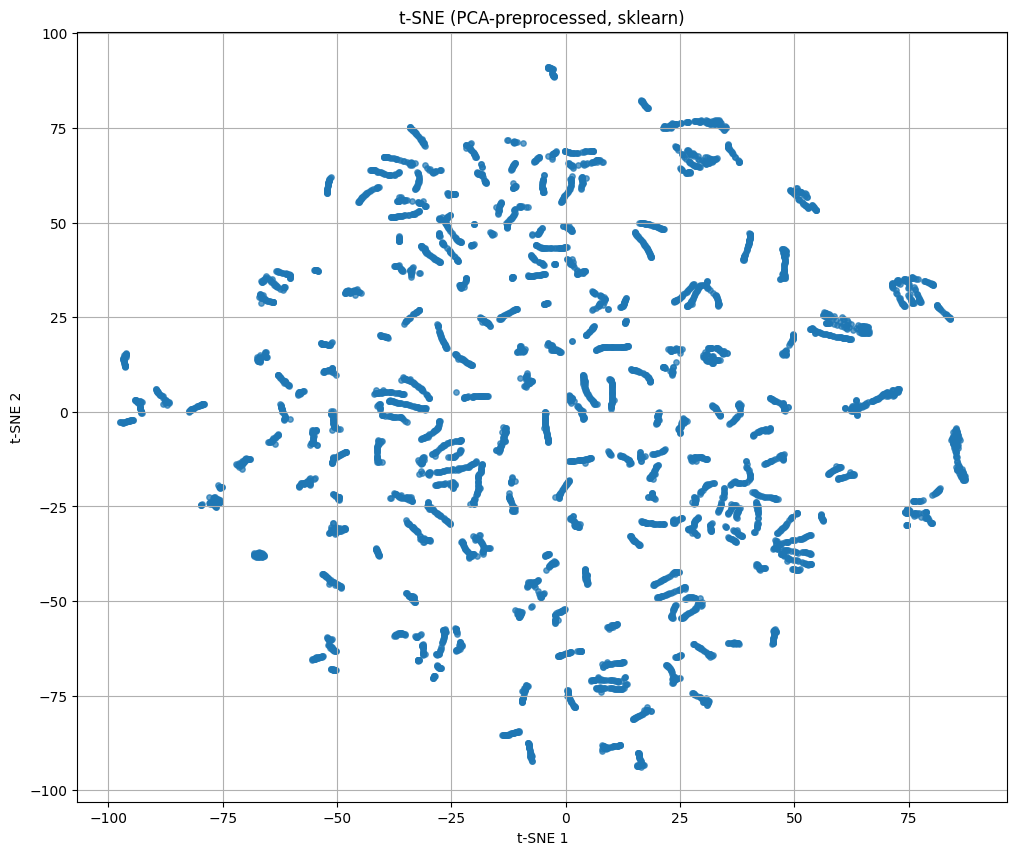

In [39]:
# Reduce dimensions with PCA, we are using openTSNE instead of sci-kit as sci-kit's TSNE implementation 
# hung and didnt work
pca = PCA(n_components=50, random_state=1)
data_pca = pca.fit_transform(numeric_np)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=1,
)

data_tsne = tsne.fit_transform(data_pca)  # note: fit_transform, not fit

# 3️⃣ Plot
plt.figure(figsize=(12, 10))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=15, alpha=0.7)
plt.title("t-SNE (PCA-preprocessed, sklearn)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


### K-Means Clustering: Initialization ###
1. We will assign K random centroids.
2. Assign each data points to a centroid using the Euclidean Distance.
3. Recompute the centroids by taking the mean of each cluster.
4. Repeat 2-3 until convergeance is reached.

In [2]:
def compute_euclidean_distance(x1, x2):
    """
    Compute and return the Euclidean distance between two vectors.
    """
    return np.linalg.norm(x1 - x2)

In [4]:
def compute_loss(centroids, clusters):
    loss = 0
    for cluster_idx, points in enumerate(clusters):
        for point in points:
            loss += compute_euclidean_distance(point, centroids[cluster_idx])**2
    return loss


In [5]:
def initialise_centroids(X, k):
    """
    Randomly selects and returns k data points as initial centroids.
        param X: The data as a (Nxd) numpy array.
        param k: The number of clusters.
    return: A list of k 1xd numpy arrays representing the initial centroids.
    """
    # Choose k unique random indices
    indices = random.sample(range(len(X)), k)
    # Return the data points at these indices
    return np.array([X[i] for i in indices])

In [94]:
def compute_cluster_mean(cluster):
    """
    Compute and return the mean of a cluster of images.
    :param cluster_list: A list of 1xd numpy arrays.
    """
    return np.mean(cluster, axis=0)

In [84]:
def initialise_centroids_KPP(X, k):
    """
    K++ initialization: selects k initial centroids from X using squared distance probability.
    This is straight from wikipedia on K++
    params:
        X: numpy array of shape (n_samples, n_features)
        k: number of centroids

    returns:
        centroids: numpy array of shape (k, n_features)
    """
    n = len(X)
    centroids = []

    first_index = random.randint(0, n - 1)
    centroids.append(X[first_index])

    while len(centroids) < k:
        distances_squared = []
        for point in X:
            # Compute squared distance to nearest existing centroid
            min_dist = np.linalg.norm(point - centroids[0])
            for c in centroids[1:]:
                d = np.linalg.norm(point - c)
                if d < min_dist:
                    min_dist = d
            distances_squared.append(min_dist ** 2)

        # Choose next centroid with probability proportional to D(x)^2
        total = sum(distances_squared)
        threshold = random.uniform(0, total)
        cumulative = 0
        for i, d_sq in enumerate(distances_squared):
            cumulative += d_sq
            if cumulative >= threshold:
                centroids.append(X[i])
                break

    return np.array(centroids)


In [8]:
def form_new_clusters(X, centroids):
    """
    Given the centroids, assign each data point in X to the closest centroid.
        param X: The data as a (Nxd) numpy array.
        param centroids: The centroids as a list of 1xd numpy arrays.

    Return a list of clusters, where each cluster is a list of data points closest to that centroid.
        return: A list of lists of 1xd numpy arrays.
    """
    clusters = [[] for _ in range(len(centroids))]
    
    for element in X:
        min_dist = float("inf")
        closest_index = -1

        for i, centroid in enumerate(centroids):
            dist = compute_euclidean_distance(element, centroid)
            if dist < min_dist:
                min_dist = dist
                closest_index = i
        
        clusters[closest_index].append(element)

    return clusters

In [9]:
def compute_new_centroids(cluster_list):
    """
    Recompute the centroids of the clusters.
    :param cluster_list: A list of lists of 1xd numpy arrays.
    :return: A list of 1xd numpy arrays.
    """
    new_centroids = []
    for cluster in cluster_list:
        if cluster:
            centroid = compute_cluster_mean(cluster)
            new_centroids.append(centroid)
        else:
            print("Cluster empty.")

    return new_centroids

### Convergence ###
Below are 4 functions/methods for determining and reaching convergeance.

In [10]:
def repeat_until_convergence_centroidChange(X, centroids, convergeance_threshold):
    """
    1. Form clusters around centroids.
    2. Compute new centroids.
    * Repeat until the centroids converge (the difference between the old and new centroids is zero, or smaller than a threshold)
    
        param X: The data as a (Nxd) numpy array.
        param centroids: The centroids as a list a k 1xd numpy arrays.
        param convergeance_threshold: The average distance between centroid reassignment threshold.

    return: 
        cluster_list: A list of lists of 1xd numpy arrays, where each list represents a cluster.
        centroids: The centroids as a list of k 1xd numpy arrays.
    """
    iteration = 1
    while (True):
        clusters = form_new_clusters(X, centroids)
        new_centroids = compute_new_centroids(clusters)
        total_distance = 0

        for i in range(len(centroids)):
            total_distance += compute_euclidean_distance(centroids[i], new_centroids[i])

        if total_distance/len(centroids) <= convergeance_threshold:
            print(f"Converged after {iteration} iterations. Average cluster change in distance: {total_distance/len(centroids)}")
            print(f"Loss: {compute_loss(X, new_centroids, clusters)}")
            return clusters, new_centroids
        
        print(f"Still converging... Iteration {iteration}, Average clusterchange in distance: {total_distance/len(centroids)}")
        print(f"Loss: {compute_loss(X, new_centroids, clusters)}")
        centroids = new_centroids 
        iteration += 1



In [12]:
def repeat_until_convergence_maxIterations(X, centroids, max_iterations):
    """
    1. Form clusters around centroids.
    2. Compute new centroids.
    * Repeat until the maximum iterations is reached or until the change in centroid assignment distance is 0.
    
        param X: The data as a (Nxd) numpy array.
        param centroids: The centroids as a list a k 1xd numpy arrays.
        param max_iterations: The amount of iterations.

    return: 
        cluster_list: A list of lists of 1xd numpy arrays, where each list represents a cluster.
        centroids: The centroids as a list of k 1xd numpy arrays.
    """
    for i in range(max_iterations):
        clusters = form_new_clusters(X, centroids)
        new_centroids = compute_new_centroids(clusters)
        total_distance = 0

        for idx in range(len(centroids)):
            total_distance += compute_euclidean_distance(centroids[idx], new_centroids[idx])

        if i == max_iterations - 1 or total_distance/len(centroids) == 0:
            print(f"Stopped at iteration {i + 1}, Average cluster change in distance: {total_distance/len(centroids)}")
            print(f"Loss: {compute_loss(new_centroids, clusters)}")

            return clusters, new_centroids
        else:
            print(f"Still converging ... Iteration {i + 1}, Average cluster change in distance: {total_distance/len(centroids)}")
            print(f"Loss: {compute_loss(new_centroids, clusters)}")

        centroids = new_centroids
        

    

In [13]:
def repeat_until_convergence_lossInertia(X, centroids, inertia_loss_threshold):
    """
    Repeats until the change in inertia goes below a certain threshold.
        param X: The data as a (Nxd) numpy array.
        param centroids: The centroids as a list a k 1xd numpy arrays.
        param inertia_loss_threshold: The threshold for convergence.

    return: 
        cluster_list: A list of lists of 1xd numpy arrays, where each list represents a cluster.
        centroids: The centroids as a list of k 1xd numpy arrays.
    """
    iterations = 1
    previous_inertia = float('inf')
    while (True):
        clusters = form_new_clusters(X, centroids)
        new_centroids = compute_new_centroids(clusters)
        inertia = compute_loss(new_centroids, clusters)

        if abs(previous_inertia - inertia) <= inertia_loss_threshold:
            print(f"Inertia Change: {abs(previous_inertia - inertia)}")
            return clusters, new_centroids
        else:
            print(f"Still converging, iteration {iterations} Loss: {inertia}")

        previous_inertia = inertia
        iterations += 1
        centroids = new_centroids
        
          
    

In [14]:
#We will be using a queue for the inertial change but over n values or over a window of size n
from collections import deque

def repeat_until_convergence_lossInertia_window(X, centroids, inertia_loss_threshold, window_size):
    """
    Repeats until the change in inertia over the last n or window_size iterations
    falls below a threshold.
        param X: The data as a (Nxd) numpy array.
        param centroids: The centroids as a list a k 1xd numpy arrays.
        param inertia_loss_threshold: The threshold for convergence.
        param window_size: The 

    return: 
        cluster_list: A list of lists of 1xd numpy arrays, where each list represents a cluster.
        centroids: The centroids as a list of k 1xd numpy arrays.
    """

    iterations = 1
    inertia_change_history = deque(maxlen=window_size)
    previous_inertia = float('inf')

    while (True):
        clusters = form_new_clusters(X, centroids)
        new_centroids = compute_new_centroids(clusters)
        inertia = compute_loss(new_centroids, clusters)
        change = abs(previous_inertia - inertia)

        inertia_change_history.append(change)

        if len(inertia_change_history) == window_size:
            avg_window_change = sum(inertia_change_history)/window_size
            if avg_window_change <= inertia_loss_threshold:
                print(f"Converged at iteration {iterations}, avg movement over last {window_size} iterations: {avg_window_change}")
                print(f"Loss: {inertia}")
                return clusters, new_centroids
        
        print(f"Loss: {inertia}")
        
        centroids = new_centroids
        iterations += 1

        

In [50]:
def label_function(X, clusters):
    """
    This label function converts our clusterlist from an array containing k clusters where each cluster in an array with
    each cluster containing the points in that cluster to an array of length X where each value corresponds to one of the k 
    clusters
        param X: The data as a (Nxd) numpy array.  
        param clusters: the list of clusters, (kxNxd) 
    return: 
        labels: a list of indices to the correspond cluster
    """
    labels = np.zeros(len(X), dtype=int) 
    for cluster_idx, cluster in enumerate(clusters):
        for point in cluster:
            idx = np.where((X == point).all(axis=1))[0][0] 
            labels[idx] = cluster_idx
    return labels
    


### Determining the Optimal K ###
We will use the **elbow method** and the **silhoutte score**, plotting both against K to determine the optimal k. We will also use **K++** as our initialisation method because its faster to calculate and there shouldn't be a difference on the optimal k.

Still converging ... Iteration 1, Average cluster change in distance: 18.86745359153037
Loss: 3515718.5068514477
Still converging ... Iteration 2, Average cluster change in distance: 4.452283467706975
Loss: 3240189.4375284486
Still converging ... Iteration 3, Average cluster change in distance: 1.7845865605968938
Loss: 3196903.897416398
Still converging ... Iteration 4, Average cluster change in distance: 0.8299029010269227
Loss: 3185069.0069535873
Still converging ... Iteration 5, Average cluster change in distance: 0.42258070112209567
Loss: 3181698.899070961
Still converging ... Iteration 6, Average cluster change in distance: 0.19694661519678291
Loss: 3180973.395860422
Still converging ... Iteration 7, Average cluster change in distance: 0.0957612824868086
Loss: 3180816.767103683
Still converging ... Iteration 8, Average cluster change in distance: 0.06852525477336588
Loss: 3180743.6997182714
Still converging ... Iteration 9, Average cluster change in distance: 0.03932359377216896
L

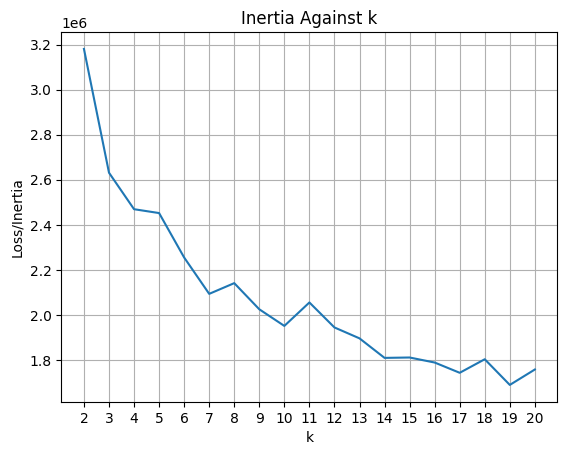

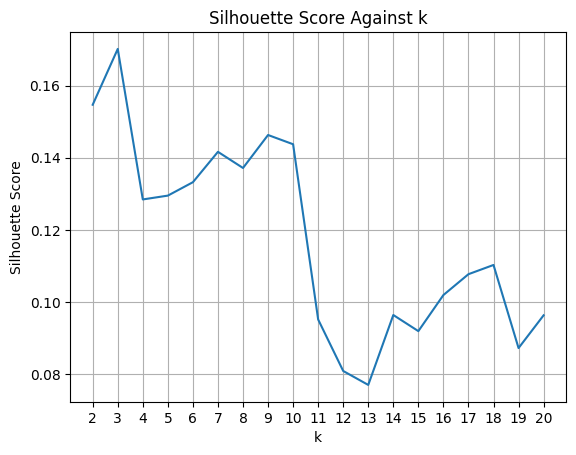

In [83]:
loss_array = []
sil_array = []

for k in range(2, 21):
    centroids = initialise_centroids_KPP(numeric_np, k)#There are 221 unique countries/regions
    clusters = form_new_clusters(numeric_np, centroids)
    final_clusters, final_centroids = repeat_until_convergence_maxIterations(numeric_np, centroids, 1000)
    labels = label_function(numeric_np, final_clusters)

    loss_array.append(compute_loss(final_centroids, final_clusters))
    print(f"k = {k}")
    sil_array.append(silhouette_score(numeric_np, labels))

k_graph_values = range(2, 2 + len(loss_array))

plt.plot(k_graph_values, loss_array)
plt.xlabel('k')
plt.ylabel('Loss/Inertia')
plt.title('Inertia Against k')
plt.xticks(range(min(k_graph_values), max(k_graph_values) + 1, 1)) #forces X axis to go up by 1 each time
plt.grid(True)
plt.show()

plt.plot(k_graph_values, sil_array)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Against k')
plt.xticks(range(min(k_graph_values), max(k_graph_values) + 1, 1))
plt.grid(True)
plt.show()



From this we can see that k = 10 is a good candidate for the optimal k. It preserves one of the higher sillhoutte scores while anything greater than 10 experiences exponential diminishing returns in loss/inertia.

Still converging ... Iteration 1, Average cluster change in distance: 13.17604473261233
Loss: 2332624.541350905
Still converging ... Iteration 2, Average cluster change in distance: 3.3039029125503356
Loss: 2254490.606381828
Still converging ... Iteration 3, Average cluster change in distance: 2.4170676728853637
Loss: 2234699.7714870432
Still converging ... Iteration 4, Average cluster change in distance: 3.1265570073709306
Loss: 2211676.851904444
Still converging ... Iteration 5, Average cluster change in distance: 0.9927650270235407
Loss: 2203861.4837745284
Still converging ... Iteration 6, Average cluster change in distance: 0.3192742787539708
Loss: 2201219.3353875885
Still converging ... Iteration 7, Average cluster change in distance: 0.2691049581326101
Loss: 2199025.9530539135
Still converging ... Iteration 8, Average cluster change in distance: 0.2758683748748944
Loss: 2196978.2686403673
Still converging ... Iteration 9, Average cluster change in distance: 0.27718134822863433
Lo

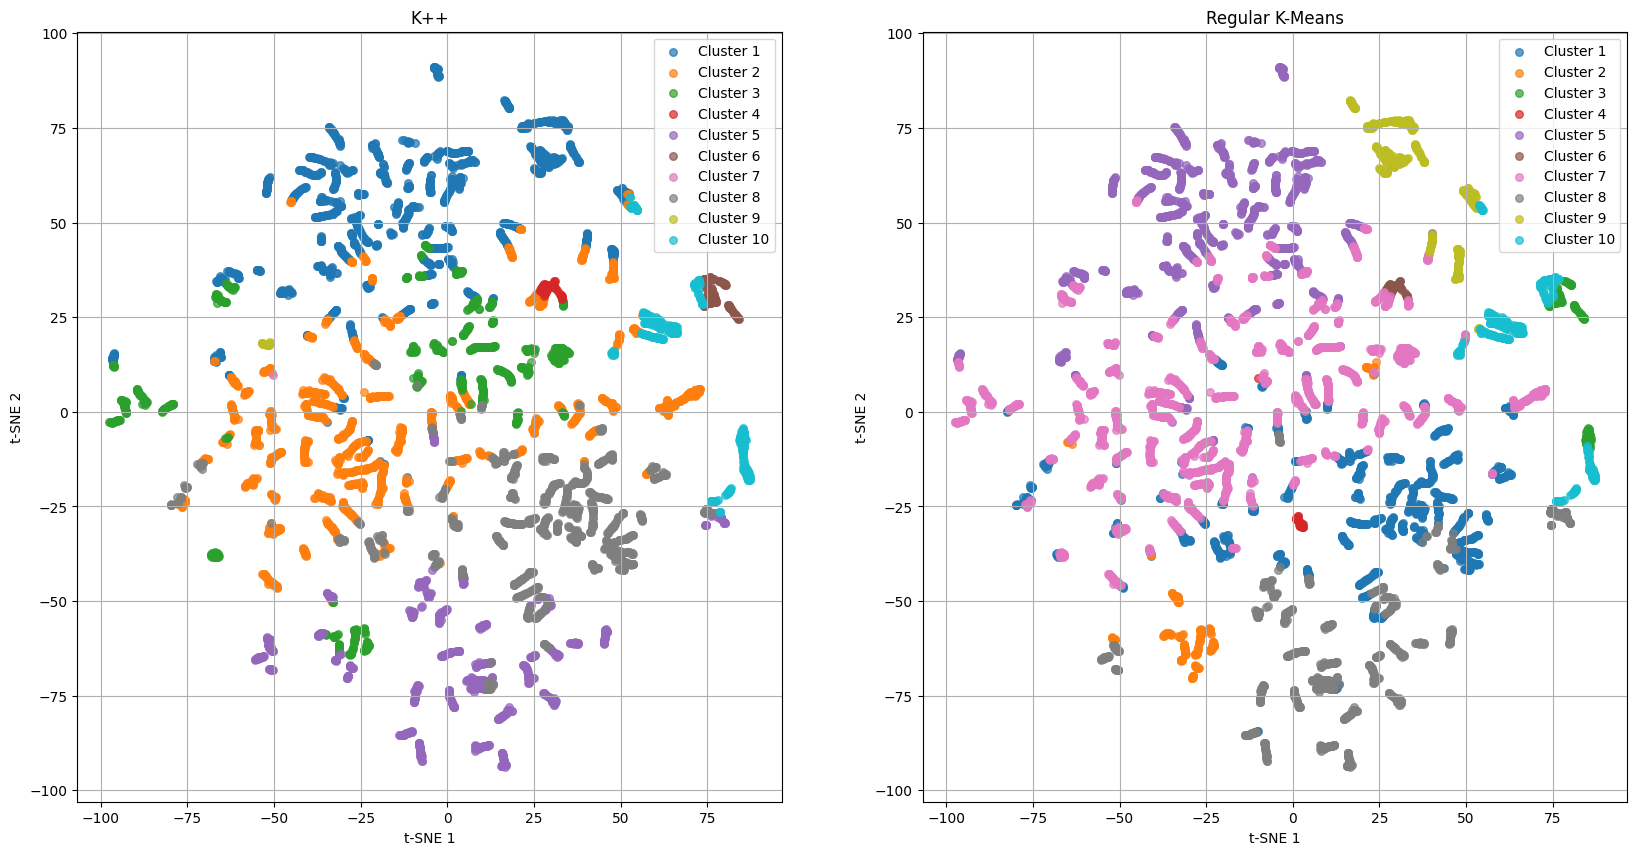

In [88]:
pca = PCA(n_components=50, random_state=1)
data_pca = pca.fit_transform(numeric_np)

tsne = TSNE(n_components=2, perplexity=30, random_state=1)
data_tsne = tsne.fit_transform(data_pca)

centroids_kpp = initialise_centroids_KPP(numeric_np, k=10)
clusters_kpp = form_new_clusters(numeric_np, centroids_kpp)
final_clusters_kpp, final_centroids_kpp = repeat_until_convergence_maxIterations(numeric_np, centroids_kpp, 1000)
labels_kpp = label_function(numeric_np, final_clusters_kpp)
sil_kpp = silhouette_score(numeric_np, labels_kpp)
print(f"K++ Silhouette score: {sil_kpp}")

centroids_normal = initialise_centroids(numeric_np, k=10)
clusters_normal = form_new_clusters(numeric_np, centroids_normal)
final_clusters_normal, final_centroids_normal = repeat_until_convergence_maxIterations(numeric_np, centroids_normal, 1000)
labels_normal = label_function(numeric_np, final_clusters_normal)
sil_normal = silhouette_score(numeric_np, labels_normal)
print(f"Regular K-Means Silhouette score: {sil_normal}")

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for cluster_idx in range(len(final_clusters_kpp)):
    axes[0].scatter(
        data_tsne[labels_kpp == cluster_idx, 0],
        data_tsne[labels_kpp == cluster_idx, 1],
        s=30, alpha=0.7,
        label=f"Cluster {cluster_idx+1}"
    )
axes[0].set_title("K++")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].legend()
axes[0].grid(True)

for cluster_idx in range(len(final_clusters_normal)):
    axes[1].scatter(
        data_tsne[labels_normal == cluster_idx, 0],
        data_tsne[labels_normal == cluster_idx, 1],
        s=30, alpha=0.7,
        label=f"Cluster {cluster_idx+1}"
    )
axes[1].set_title("Regular K-Means")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].legend()
axes[1].grid(True)

plt.show()


### Dimensionality Reduction with PCA ###
We will be applying dimensionality reduction using PCA to our data before clustering to determine the performance changes/improvements.


Still converging ... Iteration 1, Average cluster change in distance: 16.037441337201553
Loss: 1980921.4538301837
Still converging ... Iteration 2, Average cluster change in distance: 7.320250561024002
Loss: 1767197.0467430342
Still converging ... Iteration 3, Average cluster change in distance: 5.3207183561487525
Loss: 1658451.0190713247
Still converging ... Iteration 4, Average cluster change in distance: 2.5758871752329497
Loss: 1591897.3421469512
Still converging ... Iteration 5, Average cluster change in distance: 1.2493363737013548
Loss: 1567170.4606135974
Still converging ... Iteration 6, Average cluster change in distance: 0.5469262479114978
Loss: 1561581.3566926704
Still converging ... Iteration 7, Average cluster change in distance: 0.3173263260414084
Loss: 1559795.8833365168
Still converging ... Iteration 8, Average cluster change in distance: 0.2720379653795607
Loss: 1558996.8405518536
Still converging ... Iteration 9, Average cluster change in distance: 0.24584077936596413

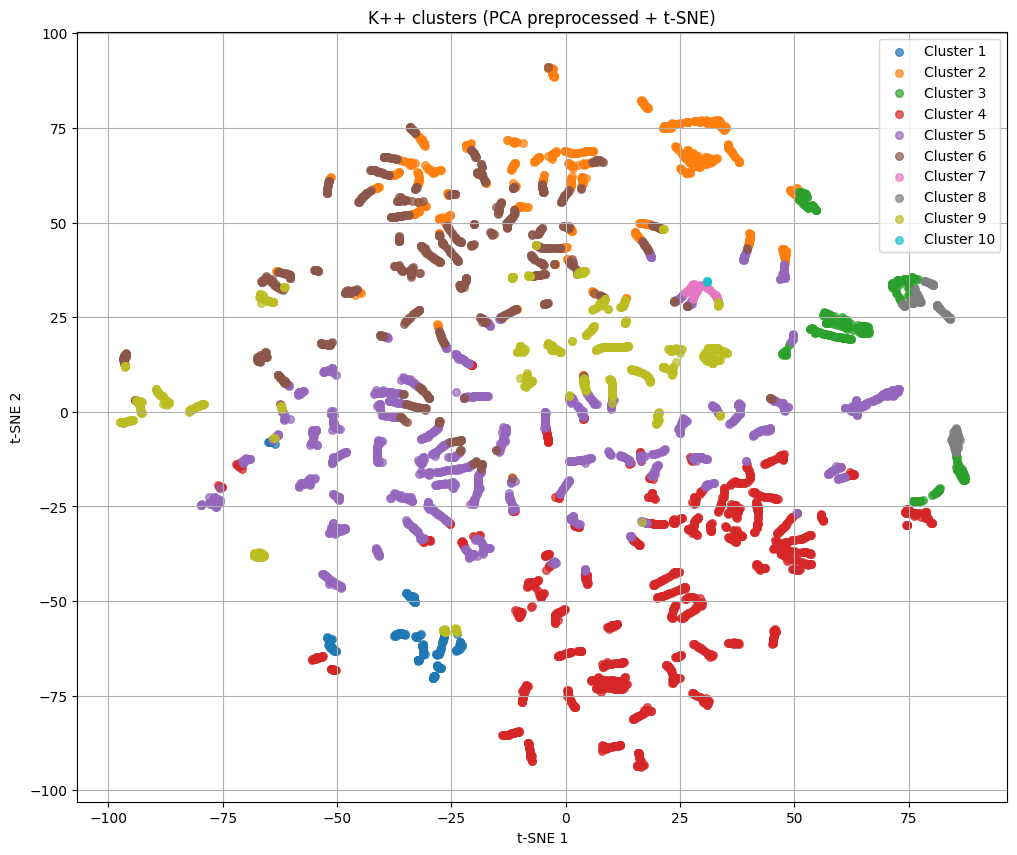

In [93]:
pca = PCA(n_components=50, random_state=1)
data_pca = pca.fit_transform(numeric_np)

centroids = initialise_centroids_KPP(data_pca, k = 10)

clusters = form_new_clusters(data_pca, centroids)

final_clusters, final_centroids = repeat_until_convergence_maxIterations(data_pca, centroids, 1000)
labels_pca = label_function(data_pca, final_clusters)
s = silhouette_score(data_pca, labels_pca)
print(f"Silhoutte score: {s}")

tsne = TSNE(n_components=2, perplexity=30, random_state=1)
data_tsne = tsne.fit_transform(data_pca)

plt.figure(figsize=(12, 10))
for cluster_idx in range(len(final_clusters)):
    plt.scatter(
        data_tsne[labels_pca == cluster_idx, 0],
        data_tsne[labels_pca == cluster_idx, 1],
        s=30, alpha=0.7,
        label=f"Cluster {cluster_idx+1}"
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("K++ clusters (PCA preprocessed + t-SNE)")
plt.legend()
plt.grid(True)
plt.show()

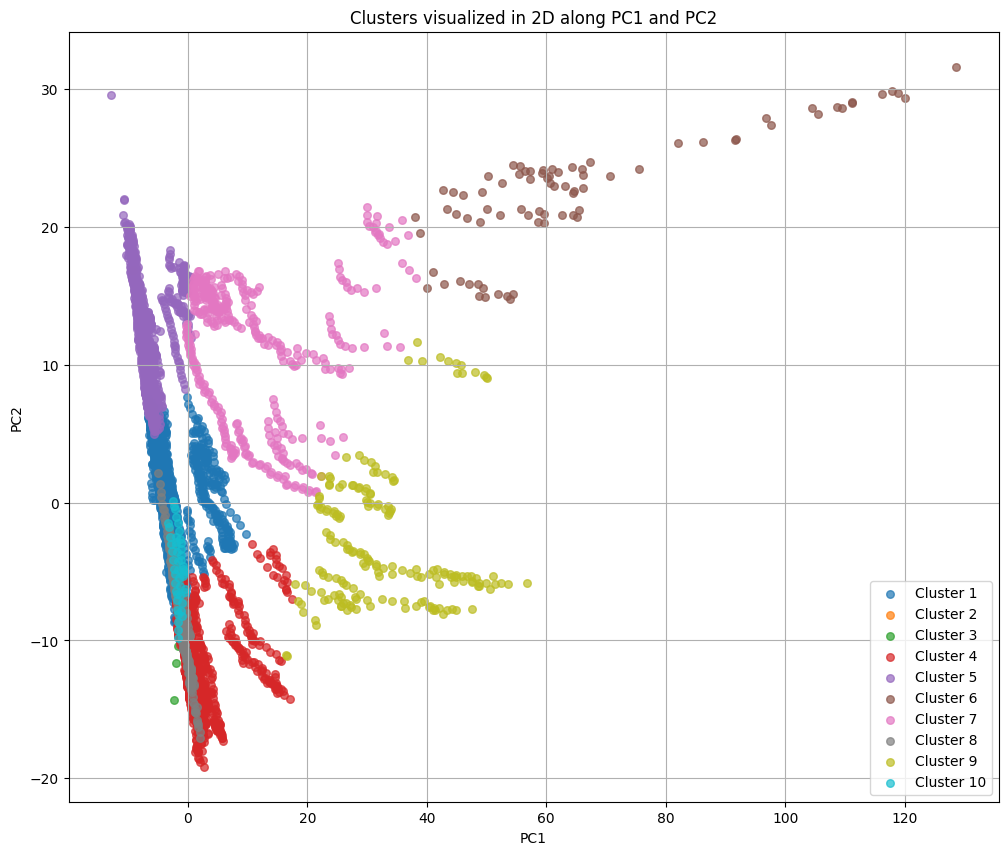

In [89]:
pca_2d = PCA(n_components=2, random_state=1)
data_2d = pca_2d.fit_transform(data_pca)

plt.figure(figsize=(12, 10))
for cluster_idx in range(len(final_clusters)):
    plt.scatter(
        data_2d[labels_pca == cluster_idx, 0],
        data_2d[labels_pca == cluster_idx, 1],
        s=30,
        alpha=0.7,
        label=f"Cluster {cluster_idx+1}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters visualized in 2D along PC1 and PC2")
plt.legend()
plt.grid(True)

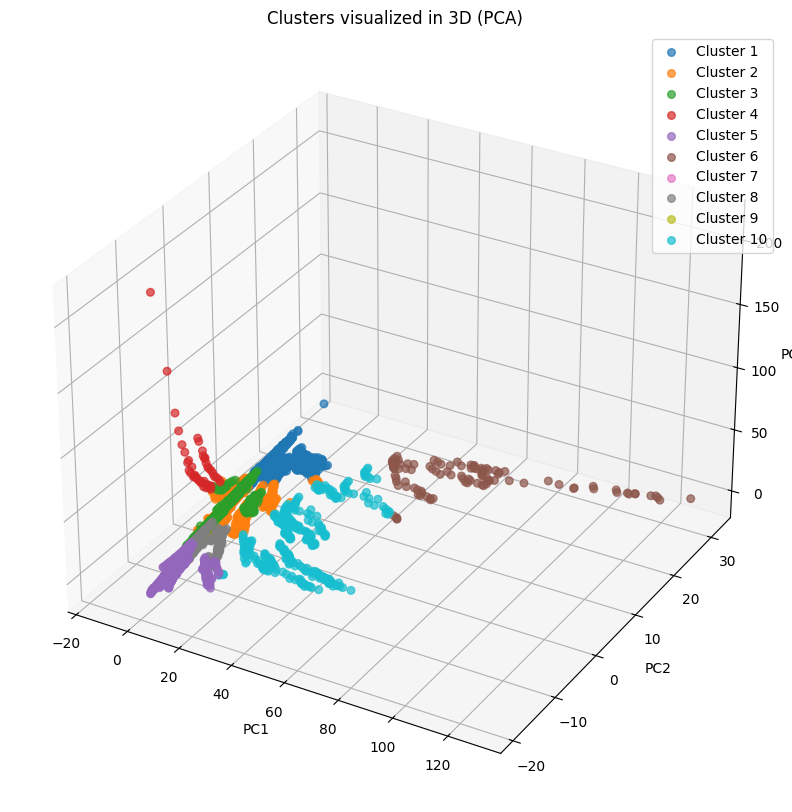

In [92]:
pca_3d = PCA(n_components=3, random_state=1)
data_3d = pca.fit_transform(numeric_np)

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for cluster_idx in range(len(final_clusters_kpp)):
    ax.scatter(
        data_3d[labels_kpp == cluster_idx, 0],
        data_3d[labels_kpp == cluster_idx, 1],
        data_3d[labels_kpp == cluster_idx, 2],
        s=30, alpha=0.7,
        label=f"Cluster {cluster_idx+1}"
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Clusters visualized in 3D (PCA)")
ax.legend()
plt.show()


The Top 3 Principle Components:

In [111]:
top3_PC = pca.explained_variance_ratio_[:3]
print(f"Top 3 explained variance ratios: {top3_PC}")
print(f"Cumulative Variance for 3 principal components: {np.sum(top3_PC)}")

top50_PC = pca.explained_variance_ratio_[:50]
print(f"Cumulative Variance for 50 principal components: {np.sum(top50_PC)}")


Top 3 explained variance ratios: [0.22240715 0.16898577 0.06163056]
Cumulative Variance for 3 principal components: 0.4530234803703223
Cumulative Variance for 50 principal components: 0.851883272527467


To get the actual features most responsible for each PC, we do the following.

In [35]:
#Drop the name columns otherwise we get an error because our dimensions arent equal
features = df.drop(columns=["Country Name", "Country Code", "Year"])



#Get loadings 
loadings = pca.components_

loading_df = pd.DataFrame(
    loadings.T,
    index = features.columns,
    columns = [f"PC{i+1}" for i in range(loadings.shape[0])]
)

def top_features(loading_df, pc = "PC1", top_n = 3):
    return loading_df[pc].abs().sort_values(ascending = False)[:top_n]

print("Top features for PC1:")
print(top_features(loading_df, "PC1"))
print()

print("Top features for PC2:")
print(top_features(loading_df, "PC2"))
print()

print("Top features for PC3:")
print(top_features(loading_df, "PC3"))


Top features for PC1:
GDP, PPP (constant 2021 international $)                     0.085189
Population ages 65 and above, female                         0.084320
Total greenhouse gas emissions excluding LULUCF (Mt CO2e)    0.084221
Name: PC1, dtype: float64

Top features for PC2:
Population ages 0-14, male (% of male population)     0.089727
Population ages 0-14 (% of total population)          0.089403
Population ages 00-04, male (% of male population)    0.088984
Name: PC2, dtype: float64

Top features for PC3:
Households and NPISHs Final consumption expenditure (current LCU)    0.158152
Final consumption expenditure (current LCU)                          0.157762
GDP: linked series (current LCU)                                     0.156923
Name: PC3, dtype: float64


These are the top 3 features responsible for PC1, PC2 and PC3 respectively.

### Cluster Interpretation ###
We will find the 3 closest country-year vectors or elements to each centroid, this will give us a rough idea of what each cluster represents.

In [103]:
def top_3_closest_points(X, centroids, df, clusters):
    """
    For each cluster, find the 3 points closest to its centroid.
    Return their Country Name and Year.
    """
    k = len(centroids)
    result = {}
    labels = label_function(X, clusters)

    for cluster_idx in range(k):
        cluster_points_idx = np.where(labels == cluster_idx)[0]
        cluster_points = X[cluster_points_idx]

        distances = np.linalg.norm(cluster_points - centroids[cluster_idx], axis=1)

        closest_indices_within_cluster = np.argsort(distances)[:3]
        closest_indices = cluster_points_idx[closest_indices_within_cluster]

        result[cluster_idx] = df.iloc[closest_indices][["Country Name", "Year"]].values.tolist()

    return result

# Example usage:
top_points = top_3_closest_points(numeric_np, final_centroids_kpp, df, final_clusters_kpp)
for cluster, points in top_points.items():
    print(f"Cluster {cluster}: {points}")


Cluster 0: [['Cameroon', 2013], ['Cameroon', 2010], ['Cameroon', 2011]]
Cluster 1: [['Ecuador', 2003], ['Ecuador', 2002], ['Ecuador', 2015]]
Cluster 2: [['Tunisia', 1997], ['Tunisia', 1991], ['Tunisia', 1998]]
Cluster 3: [['Indonesia', 2017], ['Indonesia', 2014], ['Indonesia', 2015]]
Cluster 4: [['Austria', 2006], ['Austria', 2005], ['Austria', 2007]]
Cluster 5: [['IDA & IBRD total', 2011], ['IDA & IBRD total', 2013], ['IDA & IBRD total', 2014]]
Cluster 6: [['Tonga', 2002]]
Cluster 7: [['Croatia', 2005], ['Croatia', 2006], ['Croatia', 2004]]
Cluster 8: [['Timor-Leste', 2014], ['Timor-Leste', 2015], ['Timor-Leste', 2005]]
Cluster 9: [['Late-demographic dividend', 2012], ['Late-demographic dividend', 2011], ['Late-demographic dividend', 2013]]


### Creative Extentions ##
We will be coding a Gaussian Mixture Model or GMM. This is very similar to K-Means Clustering, but instead of data values having a hard assignment (i.e it belongs to one cluster only), it uses a soft assignment. This is where a points has a certain probability of belonging to a specific cluster. We will be using Sci-Kit's built in GMM.

GMM silhouette score: 0.111589497536786


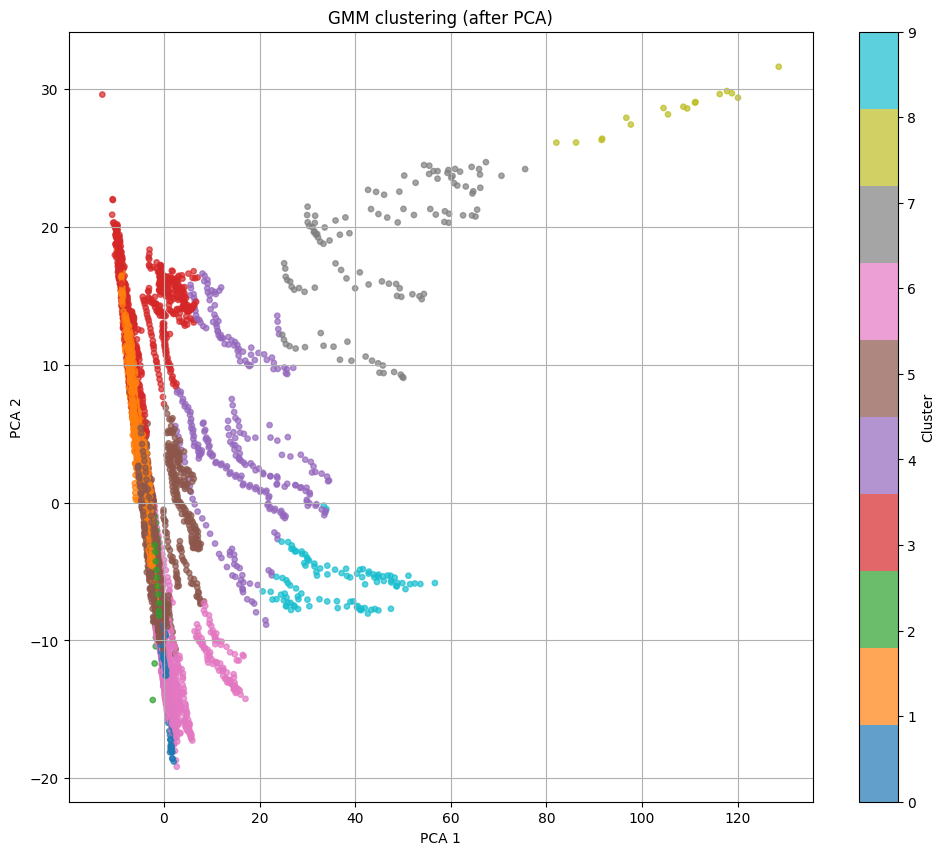

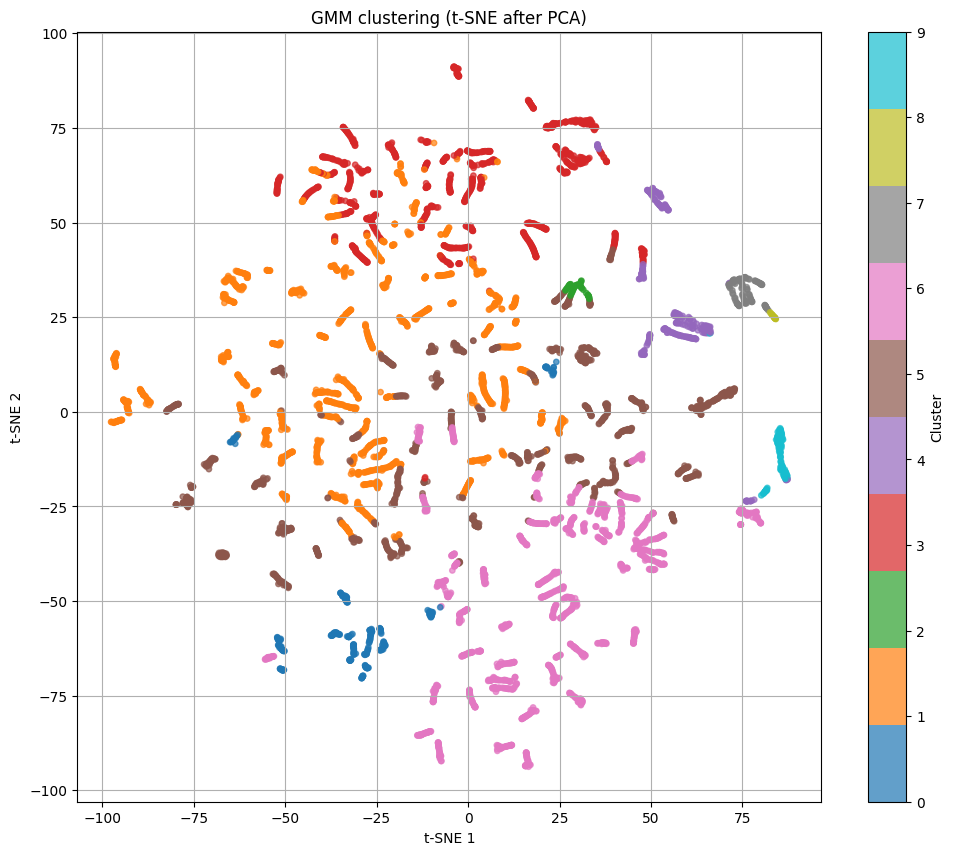

In [107]:
from sklearn.mixture import GaussianMixture

#Perform on PCA Reduced data
pca = PCA(n_components=50, random_state=1)
data_pca = pca.fit_transform(numeric_np)

k = 10
gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=1)
#This covariance type basically control how the cluster will look, if it is circular, eliptical or something in the middle.
#Full means that each cluster has its own covariance matrix and this makes it more flexible and general
gmm.fit(data_pca)

labels_gmm = gmm.predict(data_pca)

s = silhouette_score(data_pca, labels_gmm)
print(f"GMM silhouette score: {s}")

data_2d = PCA(n_components=2, random_state=1).fit_transform(data_pca)

plt.figure(figsize=(12, 10))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels_gmm, cmap="tab10", s=15, alpha=0.7)
plt.title("GMM clustering (after PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=1)
data_tsne = tsne.fit_transform(data_pca)

plt.figure(figsize=(12, 10))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels_gmm, cmap="tab10", s=15, alpha=0.7)
plt.title("GMM clustering (t-SNE after PCA)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()